In [7]:
import pandas as pd
import re 

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Sources: 
# https://nbviewer.org/github/dpanagop/ML_and_AI_examples/blob/master/NLP_example_clustering.ipynb
# https://towardsdatascience.com/clustering-documents-with-python-97314ad6a78d
# https://www.analyticsvidhya.com/blog/2019/09/introduction-information-extraction-python-spacy/?utm_source=blog&utm_medium=nlp-project-information-extraction


df = pd.read_csv('data/mit_dataset/interview_transcripts_by_turkers.csv', names=['Type', 'Transcript'])

In [8]:
## Grab only the pre interviews:

df = df.loc[~df['Type'].str.contains("pp")]
df['Interviewee'] = ''

## Split transcript to remove interviewer

df = df[:10]

for index, row in df.iterrows():
    transcript = row['Transcript']
    transcript = transcript.split("|")
    transcript = [x for x in transcript if "Interviewer" not in x]

    activities = [x for x in transcript if "activities" in x.lower()]
    interests = [x for x in transcript if "interest" in x.lower()]

    interviewee = " ".join(transcript)
    interviewee = interviewee.replace('Interviewee:', '')

    row['Interviewee'] = interviewee


In [9]:
## Create a vector

interviewees = df['Interviewee'].tolist()
# transcripts = df['Transcript'].tolist()

vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(df['Interviewee'])
# X = vectorizer.fit_transform(df['Transcript'])

Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

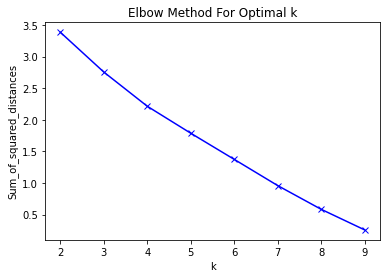

In [10]:
### Find the elbow

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [11]:
true_k = 4
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels=model.labels_
# wiki_cl=pd.DataFrame(list(labels),columns=['title','cluster'])
# print(wiki_cl.sort_values(by=['cluster']))

print(labels)

[0 1 3 2 3 2 1 2 1 1]


Cluster: 0


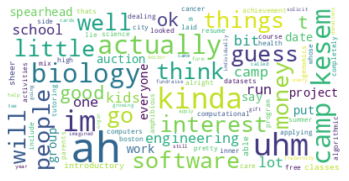

Cluster: 1


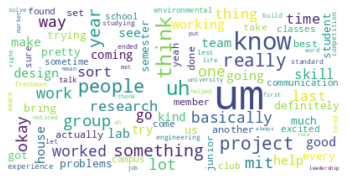

Cluster: 2


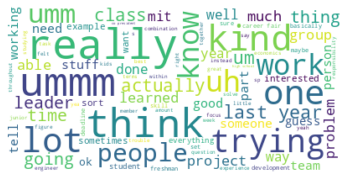

Cluster: 3


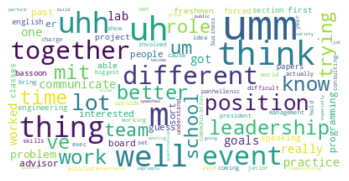

In [13]:
from wordcloud import WordCloud 
result={'cluster':labels,'wiki': interviewees} 
# result={'cluster':labels,'wiki': transcripts} 
result=pd.DataFrame(result) 
for k in range(0,true_k): 
   s=result[result.cluster==k] 
   text=s['wiki'].str.cat(sep=' ') 
   text=text.lower() 
   text=' '.join([word for word in text.split()]) 
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text) 
   print('Cluster: {}'.format(k)) 
#    print('Titles') 
#    titles=wiki_cl[wiki_cl.cluster==k]['title']          
#    print(titles.to_string(index=False)) 
   plt.figure() 
   plt.imshow(wordcloud, interpolation="bilinear") 
   plt.axis("off") 
   plt.show()